# Import packages and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
# Import training data
X_train = pd.read_csv("ais_train.csv", sep="|")
data = X_train.copy()

# Importing test data
X_test = pd.read_csv("ais_test.csv")

# Import ports data
ports = pd.read_csv("ports.csv")

# Import vessels data
vessels = pd.read_csv("vessels.csv")

#Import schedules data
schedules = pd.read_csv("schedules_to_may_2024.csv")

# Data Inspection

In [126]:
data.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [127]:
data.sample(5)

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
1430322,2024-04-30 08:19:13,325.5,1.9,3,12,0,05-02 23:00,-31.80057,115.32712,61e9f3acb937134a3c4bfe27,61d36f5d0a1807568ff9a0f7
814670,2024-03-11 22:36:17,57.4,0.0,0,345,5,02-20 08:30,54.37916,18.65987,61e9f465b937134a3c4c026b,61d37d7799db2ccf7339ef75
1086250,2024-04-02 19:16:28,71.8,0.1,3,191,1,04-01 12:00,33.68868,-118.11633,61e9f3e1b937134a3c4bff5b,61d3847fb7b7526e1adf3d1f
167449,2024-01-15 19:54:53,339.0,10.9,0,344,0,01-18 10:00,17.68177,-63.13507,61e9f404b937134a3c4c0015,634c4de270937fc01c3a7033
529861,2024-02-16 01:59:28,275.5,3.4,-4,287,0,02-12 10:00,36.98264,126.82070,61e9f43bb937134a3c4c015f,61d37a531366c3998241d97d


In [128]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cog,1522065.0,178.249396,107.678507,0.00000,78.20000,183.80000,269.00000,360.00000
sog,1522065.0,6.331703,7.539364,0.00000,0.00000,0.50000,14.10000,102.30000
rot,1522065.0,0.505456,17.609157,-127.00000,0.00000,0.00000,0.00000,128.00000
heading,1522065.0,176.273681,107.085986,0.00000,75.00000,180.00000,265.00000,511.00000
navstat,1522065.0,2.092604,2.411965,0.00000,0.00000,0.00000,5.00000,15.00000
latitude,1522065.0,36.584970,22.904879,-47.53287,34.51683,42.23370,51.35197,70.55720
longitude,1522065.0,11.536464,68.715718,-167.54093,-5.21281,4.23435,18.83715,178.80538


In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1522065 non-null  object 
 1   cog        1522065 non-null  float64
 2   sog        1522065 non-null  float64
 3   rot        1522065 non-null  int64  
 4   heading    1522065 non-null  int64  
 5   navstat    1522065 non-null  int64  
 6   etaRaw     1522065 non-null  object 
 7   latitude   1522065 non-null  float64
 8   longitude  1522065 non-null  float64
 9   vesselId   1522065 non-null  object 
 10  portId     1520450 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 127.7+ MB


In [130]:
# Check for null values
data.isnull().sum()

time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longitude       0
vesselId        0
portId       1615
dtype: int64

In [131]:
#Counted duplicate rows
len(data)-len(data.drop_duplicates())

0

In [132]:
# Count the occurence of navstat values
data['navstat'].value_counts()

navstat
0     782099
5     605831
1     129515
2       2081
8        948
15       670
6        521
4        232
3        161
11         2
12         1
13         1
14         1
7          1
9          1
Name: count, dtype: int64

<Axes: xlabel='sog'>

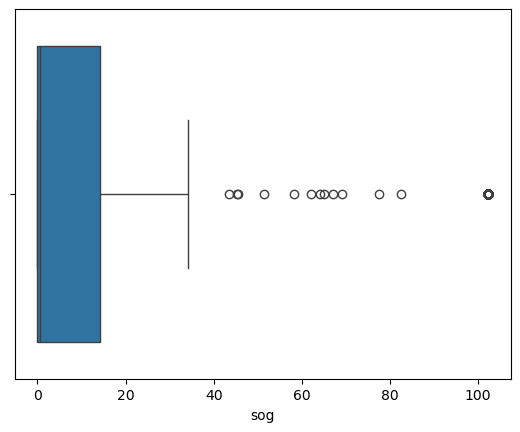

In [133]:
# Plot sog in a boxplot to get an idea of outliers
sns.boxplot(x = 'sog', data = data)

Check if in test

In [134]:
# Count number of rows with sog over 40, which seems to represent the upper outliers
(data['sog'] > 40).sum()

417

<Axes: xlabel='heading'>

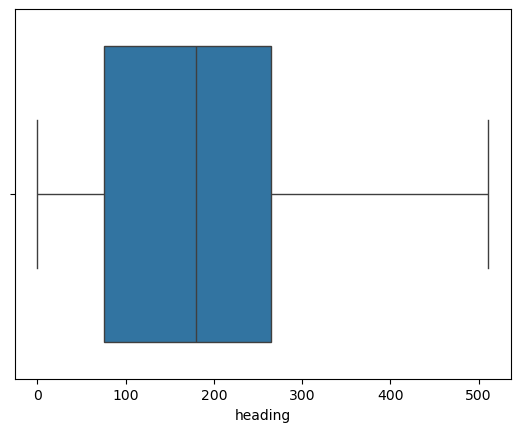

In [135]:
# Plot heading to get an idea of outliers
sns.boxplot(x = 'heading', data = data)

In [16]:
# Get the unique values in vesselID from the training and test data into a list
unique_vessels_training = data['vesselId'].unique()
unique_vessels_test = X_test['vesselId'].unique()

common_vessels = list(set(unique_vessels_training) & set(unique_vessels_test))

print('Number of vessels that are the same in training and test:', len(common_vessels))
print('Number of vessels that are in training:', len(unique_vessels_training))
print('Number of vessels that are in test:', len(unique_vessels_test))


Number of vessels that are the same in training and test: 215
Number of vessels that are in training: 688
Number of vessels that are in test: 215


# Data manipulation

## Preprocessing

In [137]:
def preprocess(df):
    data = df.copy()

    # Extract calendar features for 'etaRaw'
    data[['etaMonth', 'etaDay', 'etaHour', 'etaMinute']] = data['etaRaw'].str.extract(r'(\d{2})-(\d{2}) (\d{2}):(\d{2})')

    # Extract calendar features for 'time'
    data[['timeYear', 'timeMonth', 'timeDay', 'timeHour', 'timeMinute', 'timeSecond']] = data['time'].str.extract(r'(\d{2})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):(\d{2})')

    # Convert objects to integers
    data[['etaMonth', 'etaDay', 'etaHour', 'etaMinute', 'timeYear', 'timeMonth', 'timeDay', 'timeHour', 'timeMinute', 'timeSecond']] = data[['etaMonth', 'etaDay', 'etaHour', 'etaMinute', 'timeYear', 'timeMonth', 'timeDay', 'timeHour', 'timeMinute', 'timeSecond']].astype(int)

    # Drop time and etaRaw columns
    data.drop(columns=['time', 'etaRaw'], inplace=True)

    # Removing sog outliers 
    data = data[data['sog'] <= 40]
    
    return data

## Feature Engineering

In [149]:
def feature_engineering(df):  
    data = df.copy()

    # Preprocess the data
    data = preprocess(data)

    # Create lagged columns for longitude and latitude
    data['longitude_lag1'] = data['longitude'].shift(1)
    data['latitude_lag1'] = data['latitude'].shift(1)

    # Insert longitude and latitude lag before longitude and latitude
    data.insert(5, 'longitude_lag1', data.pop('longitude_lag1'))
    data.insert(5, 'latitude_lag1', data.pop('latitude_lag1'))

    # New feature for if the vessel is moored or not
    data['is_moored'] = data['navstat'].apply(lambda x: 1 if x == 5 else 0)
    data.insert(5, 'is_moored', data.pop('is_moored'))


    return data

In [147]:
df_preprocessed = preprocess(data)
df_preprocessed.head()

,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,etaMonth,etaDay,etaHour,etaMinute,timeYear,timeMonth,timeDay,timeHour,timeMinute,timeSecond
0,284.0,0.7,0,88,0,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,1,9,23,0,24,1,1,0,0,25
1,109.6,0.0,-6,347,1,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,12,29,20,0,24,1,1,0,0,36
2,111.0,11.0,0,112,0,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,1,2,9,0,24,1,1,0,1,45
3,96.4,0.0,0,142,1,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,12,31,20,0,24,1,1,0,3,11
4,214.0,19.7,0,215,0,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,1,25,12,0,24,1,1,0,3,51


In [150]:
df_feature_engineered = feature_engineering(data)

df_feature_engineered.head()

,cog,sog,rot,heading,navstat,is_moored,latitude_lag1,longitude_lag1,latitude,longitude,...,etaMonth,etaDay,etaHour,etaMinute,timeYear,timeMonth,timeDay,timeHour,timeMinute,timeSecond
0,284.0,0.7,0,88,0,0,NaN,NaN,-34.74370,-57.85130,...,1,9,23,0,24,1,1,0,0,25
1,109.6,0.0,-6,347,1,0,-34.74370,-57.85130,8.89440,-79.47939,...,12,29,20,0,24,1,1,0,0,36
2,111.0,11.0,0,112,0,0,8.89440,-79.47939,39.19065,-76.47567,...,1,2,9,0,24,1,1,0,1,45
3,96.4,0.0,0,142,1,0,39.19065,-76.47567,-34.41189,151.02067,...,12,31,20,0,24,1,1,0,3,11
4,214.0,19.7,0,215,0,0,-34.41189,151.02067,35.88379,-5.91636,...,1,25,12,0,24,1,1,0,3,51


In [140]:
# Check to see that the is_moored function worked
moored_rows = df_feature_engineered[df_feature_engineered['navstat']==5]
#moored_rows.head()

In [153]:
# Took out the rows for vessel 61e9f3a8b937134a3c4bfdf7
mask = data['vesselId'].values == '61e9f3a8b937134a3c4bfdf7'

df_one_vessel = data.loc[mask]
df_one_vessel = feature_engineering(df_one_vessel)

In [154]:
df_one_vessel.head()

,cog,sog,rot,heading,navstat,is_moored,latitude_lag1,longitude_lag1,latitude,longitude,...,etaMonth,etaDay,etaHour,etaMinute,timeYear,timeMonth,timeDay,timeHour,timeMinute,timeSecond
0,284.0,0.7,0,88,0,0,NaN,NaN,-34.74370,-57.85130,...,1,9,23,0,24,1,1,0,0,25
2672,92.8,14.2,0,90,0,0,-34.74370,-57.85130,-35.16787,-56.77210,...,1,9,23,0,24,1,1,6,9,8
2947,90.5,14.3,0,88,0,0,-35.16787,-56.77210,-35.16863,-56.63185,...,1,9,23,0,24,1,1,6,38,19
3093,88.2,14.3,0,86,0,0,-35.16863,-56.63185,-35.16805,-56.53190,...,1,9,23,0,24,1,1,6,58,55
3140,88.3,12.3,0,86,0,0,-35.16805,-56.53190,-35.16715,-56.45306,...,1,9,23,0,24,1,1,7,15,56


In [155]:
# Find correlation between features and longitude and latitude
df_one_vessel.corr(numeric_only=True).abs()[['longitude', 'latitude']]

,longitude,latitude
cog,0.095041,0.091378
sog,0.394124,0.390246
rot,0.027387,0.008094
heading,0.027000,0.088619
navstat,0.123589,0.201442
is_moored,0.012057,0.084927
latitude_lag1,0.243483,0.995594
longitude_lag1,0.991123,0.248673
latitude,0.247482,1.000000
longitude,1.000000,0.247482
